In [1]:
import pandas as pd
import numpy as np 
import pathlib
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from keras.layers import TimeDistributed
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# Loading the dataset 
data_dir = pathlib.Path('/home/lv11/Documents/ProyectosPython/sentimentAnalysis/datasets')
nf = pd.read_csv(data_dir / 'tweetSentiment.csv',skiprows=1,names=['Message','Target'])
len(nf)


12454

In [3]:
nlp = English()
stop_words = list(STOP_WORDS)

messages = nf['Message']
labels = nf['Target']
#print(stop_words)

def spacy_tokenizer(sentence):
    tokens = nlp(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != '-PRON-' else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuation ]
    return tokens

In [4]:
def vectorization(tweets):
    vector = CountVectorizer(tokenizer=spacy_tokenizer)
    frequency_matrix = vector.fit_transform(tweets)
    sum_frequencies = np.sum(frequency_matrix,axis=0)
    frequency = np.squeeze(np.asarray(sum_frequencies))
    frequency_dataFrame = pd.DataFrame([frequency],columns=vector.get_feature_names()).transpose()
    return frequency_dataFrame

In [5]:
def splitting(messages,labels):
    X_train,X_test,y_train,y_test = train_test_split(messages,labels,test_size=0.25,random_state=42,shuffle=True)
    return X_train,X_test,y_train,y_test

In [6]:
def tokenization_tweets(dataset,features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(dataset)
    dataset_transformed = tokenization.transform(dataset).toarray()
    return dataset_transformed

In [7]:
def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon,decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    history = model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=validation,
                 shuffle=True)
    return model_nn, history

In [8]:
def test(X_test,model):
    predict = model.predict(X_test)
    return predict

In [9]:
def modelo1(X_train,y_train):
    features = 1554 #3199 1554 1727 # puede ser 3727 o un valor asi que vi como len() del array de X_train 
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 10
    lr = 0.002
    epsilon = 1e-9
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train,features)
    modelo, history = train(X_train_mod, y_train,features,shuffle,drop,layer1,layer2,epoch,lr,epsilon,validation)
    return modelo, history

In [10]:
def modelo2(X_train,y_train):
    features = 6675 #3199 1554 1727 # puede ser 3727 o un valor asi que vi como len() del array de X_train 
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-9
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train,features)
    modelo, history = train(X_train_mod, y_train,features,shuffle,drop,layer1,layer2,epoch,lr,epsilon,validation)
    return modelo, history

In [11]:
frequency_dataFrame = vectorization(messages)

In [12]:
X_train,X_test,y_train,y_test = splitting(messages,labels)
len(X_train)

9340

In [13]:
modelo, history = modelo2(X_train,y_train)


Train on 8406 samples, validate on 934 samples
Epoch 1/5
8406/8406 [==============================] - 29s 3ms/step - loss: 0.7406 - accuracy: 0.5360 - val_loss: 0.6706 - val_accuracy: 0.5846
Epoch 2/5
8406/8406 [==============================] - 27s 3ms/step - loss: 0.6242 - accuracy: 0.6551 - val_loss: 0.6904 - val_accuracy: 0.5675
Epoch 3/5
8406/8406 [==============================] - 28s 3ms/step - loss: 0.5108 - accuracy: 0.7496 - val_loss: 0.7952 - val_accuracy: 0.5482
Epoch 4/5
8406/8406 [==============================] - 29s 3ms/step - loss: 0.3828 - accuracy: 0.8200 - val_loss: 0.9156 - val_accuracy: 0.5321
Epoch 5/5
8406/8406 [==============================] - 27s 3ms/step - loss: 0.2437 - accuracy: 0.8964 - val_loss: 1.1580 - val_accuracy: 0.5482


In [14]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               3418112   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 3,550,211
Trainable params: 3,550,211
Non-trainable params: 0
_________________________________________________________________


In [15]:
input_data = tokenization_tweets(X_test,6675) #3727 1554
#input_data

In [16]:
pred = modelo.predict(input_data)
#X_test

In [17]:
xtest = [x for x in X_test]
for i in range(len(pred)):
    sent = (1 if pred[i][1] >0.5 else 0)
    print("tweet = %s, sentiment = %s" % (xtest[i],sent))

ors. Haven`t quite worked out the angle yet, but it`ll come, sentiment = 1
tweet =  why can`t i buy the new night in for toes? i see it, it`s within my grasp, but it`s just not bringing it to my shopping cart, sentiment = 1
tweet = Dilated pupils suck. The computer screen hurts my eyes so I won`t be on the comp for a while., sentiment = 0
tweet = #SanctuarySunday  thanks for joining on #SanctuarySunday, follow more Sanctuary people to keep up to date on the tweets!, sentiment = 1
tweet = Can anyone eat a Hot Pocket and be completely satisfied?? Not me., sentiment = 1
tweet = OH EMM GEE!! QUEBEC IN 16 DAYS. I AM SO EXCITED., sentiment = 1
tweet =  SO addicted to colourlovers  Such a time sink!, sentiment = 1
tweet = i hate it when my bff is groundedd  boooooooooo, sentiment = 1
tweet = rt :  ughhhh got **** pulled over for talkin on my cell in a school zone  **** HIGHLAND PARK POLICE rude ****, sentiment = 1
tweet = grrr hate when i make careless mistakes on docs i give to my partner, s

In [18]:
i = 0
for y in y_test:
    print(xtest[i]," ---> ",y)
    i = i+1

ciate it!  You rock sir.  --->  1
 Yeah ...  I don`t know why that happened on this video...  --->  0
 You can use it for #iPhone app dev.  --->  0
@__Parasite__ haha im always turned off by coontails...so it kinda kills me XD i like the spikes though  --->  1
 I`m sad.  I want to go to the sd zoo. say hi to the giraffes and elephants and polar bears for me!  --->  0
iis back homee. Boredd. chillinq w| qrandma  ï¿½ ily Granny  --->  1
 Thank you!  --->  1
sore throat and a headache starting on a friday is not a good sign  --->  1
Well friends i think today is just gonna be one of those days........a work day  --->  0
 Ur stat pack made the LB roll. It`s like ur there!  --->  1
 http://twitpic.com/4vfcx - awesomeeeeee  --->  1
ordered my new shirt  --->  0
 hey girlie!!!  --->  0
 are you going with jordan? he told me to come but im stuck at work  --->  1
Traded her iPod for my brother`s cellphone. My phone died, e  --->  0
alright . let`s do this  --->  1
Is enjoying staying in the hou

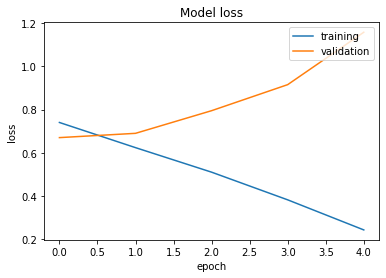

In [19]:
plt.title('Model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'],loc='upper right')
plt.show()

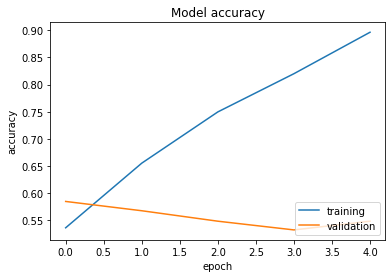

In [20]:
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [21]:
test_loss,test_acc = modelo.evaluate(input_data,y_test)

3114/3114 [==============================] - 1s 357us/step


In [22]:
print("test loss:", test_loss)
print("test accuracy:",test_acc)

test loss: 1.7881142148316174
test accuracy: 0.5269749760627747
